## Basic flow in an examplary MIR - classification research task

This notebook is designed to demonstrate basic/common flow of processes in an MIR classification task: "Automatic instrument recognition". The content should be considered as educational material rather than research material. Various segments of it aim to raise a question for discussion rather than presenting a state of the art solution.
![MIR classification task basic flow](https://raw.githubusercontent.com/MTG/MIRCourse/master/notebooks/figures/MIRresearchOverview_1.png)

**In-class discussion topics:**
* Defining the problem and the context, data space, reqirements, specifications <-> Literature review
* Curating a representative research dataset (available datasets, common/standard representation formats)
* Designing the flow, algorithms/processes/methods and implementation
* Evaluation

**Reading list:** https://sites.google.com/site/mirspring2018/my-reading-list


## A classification task: instrument recognition

* Let's pick one of the standard MIR tasks: automatic instrument recognition and limit our context as monophonic isolated notes recordings. 
* The task is a classification task hence our first aim is gather a set of isolated note recordings for various instruments with instrument labels. We will be using(downloading) samples from an existing recording collection ([the IOWA:MIS dataset](http://theremin.music.uiowa.edu/MIS.html))
* Our algorithmic design will base on the standard flow of feature extraction fed to a classifier  (see figure below)
* At the end we will use standard evaluation measures of automatic classification to test our approach.

In [1]:
#If not installed, install Essentia. 
# This cell is for running the notebook in Colab
import importlib.util
if importlib.util.find_spec('essentia') is None:
  !pip install essentia

In [2]:
#Basic imports
import os
import matplotlib.pyplot as plt
import essentia.standard as ess
import numpy as np


## Collecting raw data and investigating its nature

### Dowloading dataset files

In [3]:
#This cell downloads a subset of the UIOWA:MIS dataset
import urllib.request
import zipfile
import os, sys,shutil

#Links for some of files in the UIOWA:MIS dataset
links = {'flute':'http://theremin.music.uiowa.edu/sound%20files/MIS/Woodwinds/flute/flute.nonvib.ff.zip',
         'violin':'http://theremin.music.uiowa.edu/sound%20files/MIS/Strings/violin2012/Violin.arco.mono.1644.1.zip',
         'vibraphone': 'http://theremin.music.uiowa.edu/sound%20files/MIS%20Pitches%20-%202014/Percussion/Vibraphone/Vibraphone.dampen.ff.stereo.zip',
         'clarinet':'http://theremin.music.uiowa.edu/sound%20files/MIS/Woodwinds/Ebclarinet/EbClar.ff.zip'}

main_data_dir = 'instrument'
if not os.path.exists(main_data_dir):#creating the directory if not exist
    os.mkdir(main_data_dir)
for instrument, url in links.items():
    print('Downloading file for ', instrument)
    targetDir = os.path.join(main_data_dir,instrument)
    if not os.path.exists(targetDir):#creating the director
        os.mkdir(targetDir)
    filename = url.split('/')[-1]
    urllib.request.urlretrieve(url,filename)
    #Unzipping to a specific folder
    zip_ref = zipfile.ZipFile(filename, 'r')
    zip_ref.extractall(targetDir)
    zip_ref.close()
    os.remove(filename)#Removing the zip file
    print('Data downloaded and unzipped to: ',targetDir)
        

Data downloaded and unzipped to:  instrument/flute
Data downloaded and unzipped to:  instrument/violin
Data downloaded and unzipped to:  instrument/vibraphone
Data downloaded and unzipped to:  instrument/clarinet


**Collect file lists for each instrument**

In [4]:
main_data_dir = 'instrument'
inst_files = dict()#dictionary containing for each instrument a list that carries dictionaries
for root, dirs, files in os.walk(main_data_dir):
    for file in files:
        #Let's only keep forte recordings indicated with .ff. in the file name
        if (file.endswith('.aif') or file.endswith('.aiff')) and ('.ff.' in file):
            file_name = os.path.join(root,file)
            instrument = file.split('.')[0]#instrument name is coded in the filename
            if(len(instrument) > 0):#avoid MACOS files that start with ._
                files_instrument = inst_files.get(instrument)
                if files_instrument == None:
                    files_instrument = [file_name]
                else:
                    files_instrument.append(file_name)
                inst_files[instrument] = files_instrument

#Let's print the list of files
inst_files

{'EbClar': ['instrument/clarinet/EbClar.ff.C6A6.aiff',
  'instrument/clarinet/EbClar.ff.G3B3.aiff',
  'instrument/clarinet/EbClar.ff.C5B5.aiff',
  'instrument/clarinet/EbClar.ff.C4B4.aiff'],
 'Vibraphone': ['instrument/vibraphone/Vibraphone.dampen.ff.Db3.stereo.aif',
  'instrument/vibraphone/Vibraphone.dampen.ff.C6.stereo.aif',
  'instrument/vibraphone/Vibraphone.dampen.ff.Ab3.stereo.aif',
  'instrument/vibraphone/Vibraphone.dampen.ff.Bb3.stereo.aif',
  'instrument/vibraphone/Vibraphone.dampen.ff.Gb3.stereo.aif',
  'instrument/vibraphone/Vibraphone.dampen.ff.A5.stereo.aif',
  'instrument/vibraphone/Vibraphone.dampen.ff.E3.stereo.aif',
  'instrument/vibraphone/Vibraphone.dampen.ff.G3.stereo.aif',
  'instrument/vibraphone/Vibraphone.dampen.ff.D5.stereo.aif',
  'instrument/vibraphone/Vibraphone.dampen.ff.G4.stereo.aif',
  'instrument/vibraphone/Vibraphone.dampen.ff.Eb4.stereo.aif',
  'instrument/vibraphone/Vibraphone.dampen.ff.Eb5.stereo.aif',
  'instrument/vibraphone/Vibraphone.dampen.ff

Now that we have gather a small research dataset, we can now focus designing the basic flow for our classification task

![Basic flow](https://raw.githubusercontent.com/MTG/MIRCourse/master/notebooks/figures/classification_basicFlow.png)

### Investigating and preprocessing raw data

It is often very useful to first check a few samples from the dataset to decide what preprocessing steps are required. Let's have a look at the waveform of one sample recording for each instrument

Sample waveform plots


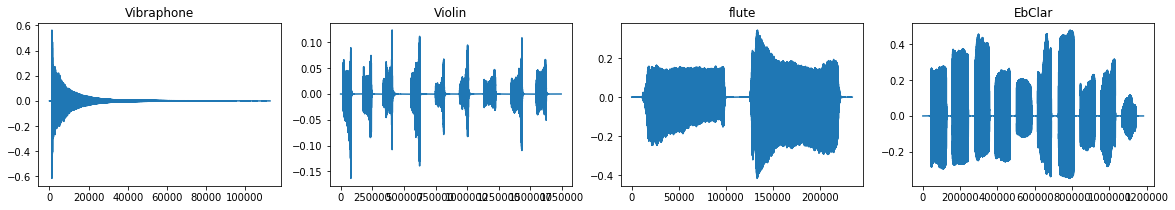

In [5]:
# Raw-data preprocess analysis parameters
fs = 44100

num_instruments = len(inst_files.keys())
print("Sample waveform plots")
plt.figure(1, figsize=(5 * num_instruments, 3))
file_ind_inlist = 0 # 0: let's take the first file in the list for sample plots
for i,instrument in enumerate(inst_files.keys()):
    sample_file = inst_files[instrument][file_ind_inlist]
    x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
    
    plt.subplot(1,num_instruments,(i+1))
    plt.plot(x)
    plt.title(instrument)

The recordings include a series of isolated notes for flute, violin and Eb-Clarinet and isolated notes for vibraphone. We could split the series of isolated notes to create the samples.

Splitting/segmentation could be performed based on energy threshold. Below, a list of heuristically selected values are used. 

### Preprocessing of raw data: Segmentation, splitting, alignment,... 

While common preprocessing steps(such as amplitude normalisation) exist, there is often some dataset and task specific preprocessing tasks required for grouping, cleaning format change. 

In the downloaded data set, recordings include a sequence of isolated notes played in sequence which could be split into isolated notes. We would like to investigate the option of spliting using a fixed energy threshold (which would help us seperate notes using the silence regions). Let's define a function to perform this operation, visualize some samples to observe the effectiveness of it.

In [0]:
# Raw-data preprocess analysis parameters
windowSize = 4096 * 4
hopSize = 4096 * 2
NRG_threshold_ratio = 0.01 #threshold expressed as ratio with respect to the maximum value
#Let's put in a container to be able to use as a single argument in function calls
params = {"fs":fs, "windowSize":windowSize, "hopSize":hopSize, "NRG_threshold_ratio": NRG_threshold_ratio}

In [0]:
#Function definition
def split_file(filename, params):
    '''Function to define split boundaries based on a fixed energy threshold
    '''
    x = ess.MonoLoader(filename = filename, sampleRate = fs)()
    NRG = [];
    #Main windowing and feature extraction loop
    for frame in ess.FrameGenerator(x, frameSize = windowSize, hopSize = hopSize, startFromZero = True):
        NRG.append(ess.Energy()(frame))
    NRG = np.array(NRG)
    NRG = NRG / np.max(NRG)
    
    #Applying energy threshold to decide wave split boundaries
    split_decision_func = np.zeros_like(NRG)
    split_decision_func[NRG > NRG_threshold_ratio] = 1
    #Setting segment boundaries
    #Inserting a zero at the beginning since we will decide the transitions using a diff function
    split_decision_func = np.insert(split_decision_func, 0, 0)
    diff_split_decision = np.diff(split_decision_func)
    #Start indexes: transition from 0 to 1
    start_indexes = np.nonzero(diff_split_decision > 0)[0] * hopSize
    #Stop indexes: transition from 1 to 0
    stop_indexes = np.nonzero(diff_split_decision < 0)[0] * hopSize
    return (x, NRG, split_decision_func, start_indexes, stop_indexes)

Let's visualize three files per instrument to check if splitting looks fine.

Sample plots for waveform versus energy and splits based on energy threshold


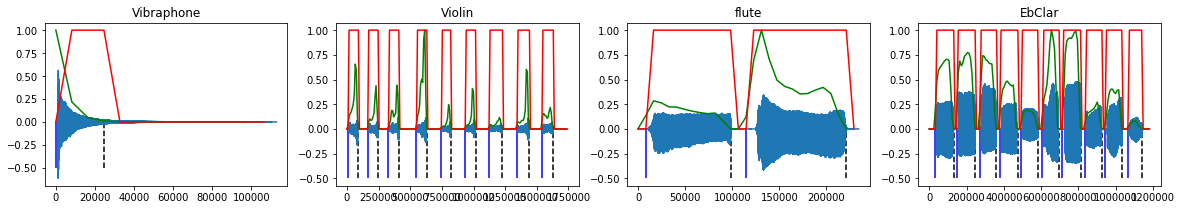

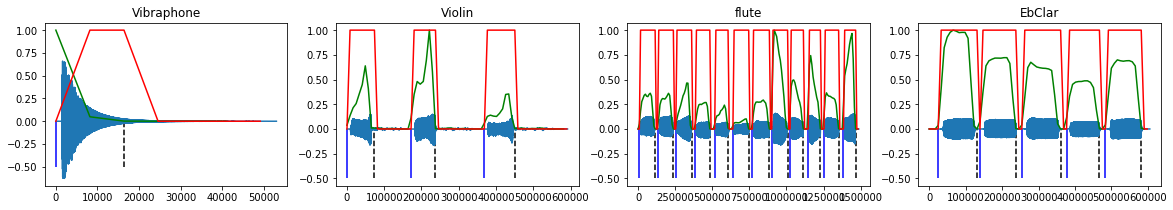

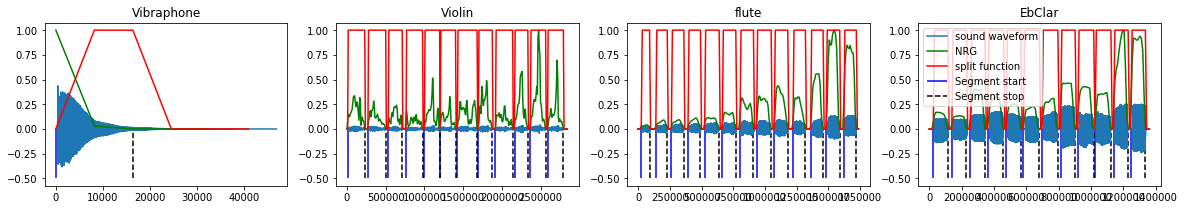

In [8]:
num_instruments = len(inst_files.keys())
print("Sample plots for waveform versus energy and splits based on energy threshold")

file_indexes = [0, 1, 2]
for file_ind_inlist in file_indexes:
    plt.figure(file_ind_inlist, figsize=(5 * num_instruments, 3))
    for i, instrument in enumerate(inst_files.keys()):
        sample_file = inst_files[instrument][file_ind_inlist]
        (x, NRG, split_decision_func, start_indexes, stop_indexes) = split_file(sample_file, params)
        #Plotting functions for checking the split decisions
        plt.subplot(1,num_instruments,(i+1))
        plt.title(instrument)
        plt.plot(x, label = 'sound waveform')
        plt.plot(np.arange(NRG.size) * hopSize, NRG, 'g', label = 'NRG')
        plt.plot(np.arange(split_decision_func.size) * hopSize, split_decision_func,'r', label = 'split function')
        plt.vlines(start_indexes, ymin = -0.5, ymax = 0, colors='b', linestyles='solid', label='Segment start')
        plt.vlines(stop_indexes, ymin = -0.5, ymax = 0, colors='k', linestyles='dashed', label='Segment stop')

plt.legend(loc="best");


The decision boundaries look fine, let's use the function to 
* get segment boundaries and crop segments, 
* amplitude normalize them and save all segments in a new folder

In [9]:
segments_dir = os.path.join(main_data_dir,'segments')
if not os.path.exists(segments_dir):#creating the directory
    os.mkdir(segments_dir)

segment_files = []
for instrument, files in inst_files.items():
    file_count = 0
    for sample_file in files:
        x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
        (x, NRG, split_decision_func, start_indexes, stop_indexes) = split_file(sample_file, params)
        #Croping segments
        for start, stop in zip(start_indexes, stop_indexes):
            if stop - start > fs/3:#let's only keep segments larger than 1/3 second
                x_seg = x[start: stop]
                #Final check for amplitude (to avoid silent segments selection due to noise in split function)
                if(np.max(np.abs(x_seg)) > 0.05):
                    #Amplitude normalisation
                    x_seg = x_seg / np.max(np.abs(x_seg))
                    filename = os.path.join(segments_dir, instrument + '_' + str(file_count) + '.wav')
                    ess.MonoWriter(filename = filename, format = 'wav', sampleRate = fs)(x_seg)
                    file_count +=1
                    segment_files.append(filename)

print(len(segment_files),'segment files created')

193 segment files created


In [0]:
#If required, you can use this cell to delete all files in a given folder
def delete_files_in_dir(dir_name):
    '''Deleting all files in a directory
    '''
    for root, dirs, files in os.walk(dir_name):
        for file in files:
            file_name = os.path.join(root,file)
            os.remove(file_name);print(file_name, 'removed');

#delete_files_in_dir(segments_dir)

Segments saved into separate files. Check the "data/instrument/segments/" folder.

## Feature extraction 

Let's compute a list of common features for each of the files and form a data frame including features and categories. We will be using the [MusicExtractor function of Essentia](https://essentia.upf.edu/documentation/reference/std_MusicExtractor.html). 

Let's first run it for a file and check its output:

In [0]:
import essentia.standard as es

#Running music extractor for a file:
file = segment_files[0]#simply pick the first file in the list
features, features_frames = es.MusicExtractor(lowlevelSilentFrames='drop',
                                                  lowlevelFrameSize = 2048,
                                                  lowlevelHopSize = 1024,
                                                  lowlevelStats = ['mean', 'stdev'])(file)

Essentia-MusicExtractor extracts a large number of features. For simplicity, let's only keep low-level descriptors which are represented with a single scalar value as our feature set and discard other features.

In [12]:
scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() if 'lowlevel' in descriptor and isinstance(features[descriptor], float)]
print("Subset of features to be considered:\n",scalar_lowlevel_descriptors)

Subset of features to be considered:
 ['lowlevel.average_loudness', 'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.stdev', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.stdev', 'lowlevel.barkbands_kurtosis.mean', 'lowlevel.barkbands_kurtosis.stdev', 'lowlevel.barkbands_skewness.mean', 'lowlevel.barkbands_skewness.stdev', 'lowlevel.barkbands_spread.mean', 'lowlevel.barkbands_spread.stdev', 'lowlevel.dissonance.mean', 'lowlevel.dissonance.stdev', 'lowlevel.dynamic_complexity', 'lowlevel.erbbands_crest.mean', 'lowlevel.erbbands_crest.stdev', 'lowlevel.erbbands_flatness_db.mean', 'lowlevel.erbbands_flatness_db.stdev', 'lowlevel.erbbands_kurtosis.mean', 'lowlevel.erbbands_kurtosis.stdev', 'lowlevel.erbbands_skewness.mean', 'lowlevel.erbbands_skewness.stdev', 'lowlevel.erbbands_spread.mean', 'lowlevel.erbbands_spread.stdev', 'lowlevel.hfc.mean', 'lowlevel.hfc.stdev', 'lowlevel.loudness_ebu128.integrated', 'lowlevel.loudness_ebu128.loudness_range', 'lowlev

Running musicextractor for all files, keeping a subset of features, writing to an output file: data.csv

In [13]:
#Extracting features and writing in data.csv file in the segments folder
#  each line in the data.csv file represents a sample with features and the class information as the last element
data_file = os.path.join(segments_dir,'data.csv')
file_count = 0
with open(data_file, 'w') as writer:
    #adding column names as the first line in csv
    line2write = ','.join(scalar_lowlevel_descriptors + ['instrument']).replace('lowlevel.','') + '\n'
    writer.write(line2write)
    for file in segment_files:
        if '.wav' in file:
            file_count +=1
            if file_count % 20 == 0:#print name of a file every 20 files
                print(file_count, "files processed, current file: ",file)
            features, features_frames = es.MusicExtractor(lowlevelSilentFrames='drop',
                                                          lowlevelFrameSize = 2048,
                                                          lowlevelHopSize = 1024,
                                                          lowlevelStats = ['mean', 'stdev'])(file)
            selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
            instrument = file.split('/')[-1].split('_')[0].lower()#class information
            line2write = str(selected_features)[1:-1] + ',' + instrument + '\n'
            writer.write(line2write)
print("A total of ",file_count, "files processed")

20 files processed, current file:  instrument/segments/Vibraphone_19.wav
40 files processed, current file:  instrument/segments/Vibraphone_39.wav
60 files processed, current file:  instrument/segments/Violin_17.wav
80 files processed, current file:  instrument/segments/Violin_37.wav
100 files processed, current file:  instrument/segments/Violin_57.wav
120 files processed, current file:  instrument/segments/flute_1.wav
140 files processed, current file:  instrument/segments/flute_21.wav
160 files processed, current file:  instrument/segments/EbClar_5.wav
180 files processed, current file:  instrument/segments/EbClar_25.wav
A total of  193 files processed


## Analysis and preprocessing of features

All extracted features are saved in data.csv. Columns represent features and rows each file/sample. This is a typical format in a large number of machine learning datasets (see a few of the dataset here: https://archive.ics.uci.edu/ml/index.php or other "Data Science" examples on the web).  

***The use of a common format for data representation is beneficial in both making use of existing tools (such as Pandas) as well as contributing to the community with resources that are easy to use.***

Let's load the data and start investigating the features. We can use Pandas(a package largely used in data science) to read data and access statistical description of the features. 

In [0]:
import pandas as pd

In [15]:
#Read data
data = pd.read_csv(data_file)
#Let's see the first lines of our data
data.head()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,barkbands_spread.stdev,dissonance.mean,dissonance.stdev,dynamic_complexity,erbbands_crest.mean,erbbands_crest.stdev,erbbands_flatness_db.mean,erbbands_flatness_db.stdev,erbbands_kurtosis.mean,erbbands_kurtosis.stdev,erbbands_skewness.mean,erbbands_skewness.stdev,erbbands_spread.mean,erbbands_spread.stdev,hfc.mean,hfc.stdev,loudness_ebu128.integrated,loudness_ebu128.loudness_range,loudness_ebu128.momentary.mean,loudness_ebu128.momentary.stdev,loudness_ebu128.short_term.mean,loudness_ebu128.short_term.stdev,melbands_crest.mean,melbands_crest.stdev,melbands_flatness_db.mean,melbands_flatness_db.stdev,melbands_kurtosis.mean,melbands_kurtosis.stdev,melbands_skewness.mean,melbands_skewness.stdev,...,silence_rate_20dB.stdev,silence_rate_30dB.mean,silence_rate_30dB.stdev,silence_rate_60dB.mean,silence_rate_60dB.stdev,spectral_centroid.mean,spectral_centroid.stdev,spectral_complexity.mean,spectral_complexity.stdev,spectral_decrease.mean,spectral_decrease.stdev,spectral_energy.mean,spectral_energy.stdev,spectral_energyband_high.mean,spectral_energyband_high.stdev,spectral_energyband_low.mean,spectral_energyband_low.stdev,spectral_energyband_middle_high.mean,spectral_energyband_middle_high.stdev,spectral_energyband_middle_low.mean,spectral_energyband_middle_low.stdev,spectral_entropy.mean,spectral_entropy.stdev,spectral_flux.mean,spectral_flux.stdev,spectral_kurtosis.mean,spectral_kurtosis.stdev,spectral_rms.mean,spectral_rms.stdev,spectral_rolloff.mean,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev,instrument
0,0.990684,23.565981,4.597108,0.425580,0.135100,59.750126,54.249294,-6.715064,3.709976,8.052088,18.293867,0.469035,0.087536,3.585326,31.459240,7.318438,0.496079,0.127109,217.838882,146.570282,-8.758108,4.068635,3.037251,10.222582,16.353476,20.245600,-18.553127,0.0,-19.457064,2.8948,-24.600954,0.0,24.530735,4.666090,0.426847,0.125451,15.603864,14.711027,-3.366636,2.305021,...,0.0,1.0,0.0,0.480000,0.499600,2259.015381,213.114243,3.160000,3.145537,-1.649580e-09,2.011615e-09,0.007709,0.009425,0.000005,0.000009,2.860400e-04,4.460677e-04,0.007363,0.009032,0.000190,0.000285,4.641081,1.437000,0.022451,0.039796,67.659836,37.797817,0.002245,0.001575,2504.743164,1236.714355,5.807151,2.171991,2031812.750,1917426.125,5.219348,3.358985,0.101094,0.015830,vibraphone
1,0.990684,20.838055,3.613236,0.522126,0.162409,77.388107,28.494204,1.492320,3.118320,5.768398,21.360468,0.243603,0.110717,0.000000,31.284981,7.571612,0.544165,0.147244,92.983047,40.157734,4.994373,2.284029,3.743249,12.942805,17.503464,30.114408,-12.334029,0.0,-12.334029,0.0000,-21.084641,0.0,24.808121,1.955757,0.581418,0.164880,96.079041,37.020832,-1.702168,4.172208,...,0.0,1.0,0.0,0.470588,0.499134,1072.998291,47.755260,1.294118,0.892103,-3.959896e-09,6.807650e-09,0.016533,0.028425,0.000007,0.000018,1.767700e-06,1.765965e-06,0.016521,0.028405,0.000005,0.000007,3.873822,1.248546,0.039812,0.066735,70.870773,30.712952,0.002833,0.002847,1518.724121,1784.516235,6.307875,1.489496,1585815.875,1362501.375,3.390413,3.502191,0.056009,0.025741,vibraphone
2,0.990684,17.843521,2.752565,0.416003,0.087352,-0.159729,2.314038,-1.012197,0.697896,20.589605,7.211400,0.403652,0.094151,0.000000,17.632961,0.895091,0.437947,0.060296,11.962613,11.858167,-3.186878,1.135856,10.443872,3.794617,15.624939,24.586929,-11.694408,0.0,-11.694408,0.0000,-20.445021,0.0,18.535152,3.288275,0.454366,0.095340,-1.292677,0.634444,0.001804,0.698087,...,0.0,1.0,0.0,0.529412,0.499134,1751.756348,160.072250,2.823529,2.036008,-2.221713e-09,3.118171e-09,0.009802,0.013958,0.000003,0.000007,3.998082e-07,5.027738e-07,0.007292,0.011573,0.002512,

All features are represented with columns and the last column('instrument') carries the class information

Always check if your data involves Nan values and clean them (by: simply removing the sample, or replacing the Nan value by a real value (such as the median of that feature)) 

In [16]:
data.isnull().sum().sum()#sums a matrix of True/False values obtained by checking if each value is Nan

0

**Observation:** No Nan value, proceed ..

As the next step, having a look at descriptive statistics of the features would be useful. Let's do that

In [17]:
#Descriptive statistics of the features:
data.describe()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,barkbands_spread.stdev,dissonance.mean,dissonance.stdev,dynamic_complexity,erbbands_crest.mean,erbbands_crest.stdev,erbbands_flatness_db.mean,erbbands_flatness_db.stdev,erbbands_kurtosis.mean,erbbands_kurtosis.stdev,erbbands_skewness.mean,erbbands_skewness.stdev,erbbands_spread.mean,erbbands_spread.stdev,hfc.mean,hfc.stdev,loudness_ebu128.integrated,loudness_ebu128.loudness_range,loudness_ebu128.momentary.mean,loudness_ebu128.momentary.stdev,loudness_ebu128.short_term.mean,loudness_ebu128.short_term.stdev,melbands_crest.mean,melbands_crest.stdev,melbands_flatness_db.mean,melbands_flatness_db.stdev,melbands_kurtosis.mean,melbands_kurtosis.stdev,melbands_skewness.mean,melbands_skewness.stdev,...,silence_rate_20dB.mean,silence_rate_20dB.stdev,silence_rate_30dB.mean,silence_rate_30dB.stdev,silence_rate_60dB.mean,silence_rate_60dB.stdev,spectral_centroid.mean,spectral_centroid.stdev,spectral_complexity.mean,spectral_complexity.stdev,spectral_decrease.mean,spectral_decrease.stdev,spectral_energy.mean,spectral_energy.stdev,spectral_energyband_high.mean,spectral_energyband_high.stdev,spectral_energyband_low.mean,spectral_energyband_low.stdev,spectral_energyband_middle_high.mean,spectral_energyband_middle_high.stdev,spectral_energyband_middle_low.mean,spectral_energyband_middle_low.stdev,spectral_entropy.mean,spectral_entropy.stdev,spectral_flux.mean,spectral_flux.stdev,spectral_kurtosis.mean,spectral_kurtosis.stdev,spectral_rms.mean,spectral_rms.stdev,spectral_rolloff.mean,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev
count,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.0,193.000000,193.000000,193.000000,193.0,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,...,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,1.930000e+02,1.930000e+02,193.000000,193.000000,1.930000e+02,193.000000,1.930000e+02,1.930000e+02,193.000000,193.000000,1.930000e+02,1.930000e+02,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,1.930000e+02,1.930000e+02,193.000000,193.000000,193.000000,193.000000
mean,0.986378,18.737075,3.533494,0.430367,0.102611,283.950436,628.912521,3.632873,4.466254,9.637900,8.297742,0.378581,0.068661,4.423657,20.334707,5.178872,0.409486,0.094720,18.817250,17.592866,1.235512,1.443289,16.547586,12.781241,24.323515,17.045091,-9.917248,0.0,-11.125669,2.664602,-13.647154,0.0,23.737525,4.502573,0.450065,0.104105,3012.575911,7499.255243,7.647195,11.267097,...,0.999869,0.000814,0.999171,0.002782,0.231555,0.371828,1458.036380,400.415318,4.438503,2.036040,-5.512389e-09,3.731882e-09,0.023011,0.015592,2.104459e-04,0.000250,1.485447e-04,2.915556e-04,0.012854,0.008831,9.800995e-03,6.792110e-03,5.101570,1.056068,0.020691,0.023357,28.524502,18.527053,0.004050,0.001959,1540.656583,760.391840,3.335839,1.303501,3.089806e+06,2.443487e+06,3.835344,2.347946,0.055322,0.022904
std,0.006414,4.673740,1.205451,0.079073,0.040251,999.687053,2476.937968,6.138560,7.892060,6.017748,4.982078,0.078875,0.025878,4.426984,6.022991,1.960102,0.080642,0.037934,33.644639,19.463037,2.281535,0.861485,9.802134,7.523653,13.451981,6.738825,3.348636,0.0,4.445027,3.530941,5.392517,0.0,5.772736,2.122230,0.086242,0.043252,14622.096981,36752.063325,22.480858,37.341062,..

**Observation:** min, max, mean values of the features vary a lot, we need to normalise them. Some of the features(such as average loudness) are irrelevant for the task. For simplicity of the code here, we will keep all the features as is, but you should consider removing irrelevant features from the list.   

### Preprocessing of the features

**Normalisation of the features**

In [0]:
data_modif = data.copy()
#Let's use sklearn's preprocessing tools for applying normalisation to features
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data_modif.iloc[:,:84] = min_max_scaler.fit_transform(data.iloc[:,:84].values)

In [19]:
data_modif.describe()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,barkbands_spread.stdev,dissonance.mean,dissonance.stdev,dynamic_complexity,erbbands_crest.mean,erbbands_crest.stdev,erbbands_flatness_db.mean,erbbands_flatness_db.stdev,erbbands_kurtosis.mean,erbbands_kurtosis.stdev,erbbands_skewness.mean,erbbands_skewness.stdev,erbbands_spread.mean,erbbands_spread.stdev,hfc.mean,hfc.stdev,loudness_ebu128.integrated,loudness_ebu128.loudness_range,loudness_ebu128.momentary.mean,loudness_ebu128.momentary.stdev,loudness_ebu128.short_term.mean,loudness_ebu128.short_term.stdev,melbands_crest.mean,melbands_crest.stdev,melbands_flatness_db.mean,melbands_flatness_db.stdev,melbands_kurtosis.mean,melbands_kurtosis.stdev,melbands_skewness.mean,melbands_skewness.stdev,...,silence_rate_20dB.mean,silence_rate_20dB.stdev,silence_rate_30dB.mean,silence_rate_30dB.stdev,silence_rate_60dB.mean,silence_rate_60dB.stdev,spectral_centroid.mean,spectral_centroid.stdev,spectral_complexity.mean,spectral_complexity.stdev,spectral_decrease.mean,spectral_decrease.stdev,spectral_energy.mean,spectral_energy.stdev,spectral_energyband_high.mean,spectral_energyband_high.stdev,spectral_energyband_low.mean,spectral_energyband_low.stdev,spectral_energyband_middle_high.mean,spectral_energyband_middle_high.stdev,spectral_energyband_middle_low.mean,spectral_energyband_middle_low.stdev,spectral_entropy.mean,spectral_entropy.stdev,spectral_flux.mean,spectral_flux.stdev,spectral_kurtosis.mean,spectral_kurtosis.stdev,spectral_rms.mean,spectral_rms.stdev,spectral_rolloff.mean,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev
count,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.0,193.000000,193.000000,193.000000,193.0,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,...,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000
mean,0.906580,0.591483,0.343479,0.452100,0.308379,0.031269,0.027894,0.268080,0.075494,0.354164,0.249978,0.696499,0.430023,0.165118,0.491039,0.449850,0.448539,0.375408,0.092498,0.118580,0.604728,0.278533,0.338367,0.262195,0.308666,0.303701,0.635691,0.0,0.725057,0.137072,0.595028,0.0,0.560605,0.317034,0.441609,0.296483,0.024724,0.022686,0.079972,0.044893,...,0.994819,0.005181,0.991809,0.009223,0.283841,0.744252,0.324924,0.211524,0.319851,0.286902,0.723979,0.091972,0.294569,0.094748,0.044869,0.031066,0.012969,0.009324,0.256575,0.266706,0.238588,0.282456,0.514041,0.471943,0.227734,0.190554,0.161212,0.159734,0.508402,0.256061,0.286764,0.268415,0.268138,0.200224,0.328036,0.372892,0.281965,0.186165,0.262671,0.163856
std,0.139165,0.245692,0.176400,0.210464,0.172347,0.109675,0.109949,0.148056,0.139642,0.229681,0.157313,0.205952,0.184520,0.165242,0.233294,0.205835,0.239059,0.217422,0.153413,0.133009,0.138059,0.195104,0.208770,0.162348,0.223217,0.170340,0.188605,0.0,0.161645,0.181638,0.242604,0.0,0.230439,0.185987,0.202234,0.171969,0.119952,0.111183,0.139022,0.152791,...,0.071982,0.071982,0.083056,0.091056,0.218392,0.180650,0.197053,0.142425,0.206252,0.155656,0.176808,0.077056,

**Observation:** Now the features are normalised in [0,1] range, proceed to converting data into matrices that can be fed into classifiers

**IMPORTANT:** Various other preprocessing may be required based on the nature of your data. Refer to your machine learning course for the preprocessing step. We will also skip discussions on feature selection(another important topic) here and leave it to your machine learning course. 

We should check if our data is balanced:

In [20]:
data_modif.instrument.value_counts()

violin        76
vibraphone    42
ebclar        39
flute         36
Name: instrument, dtype: int64

**Observation:** our data is imbalanced, ups.... refer to your machine learning course for the problem of working with imbalanced datasets. Here, we will simply throw out some samples to balance our data

### Balancing the data
Let's simply pick 36 samples randomly from each instrument samples (since the lowest number of samples in a class is 36 (flute))

In [21]:
min_number = data_modif.instrument.value_counts()['flute']
violin_data = data_modif[data_modif.instrument == 'violin'].sample(n = min_number)
vibraphone_data = data_modif[data_modif.instrument == 'vibraphone'].sample(n = min_number)
ebclar_data = data_modif[data_modif.instrument == 'ebclar'].sample(n = min_number)
flute_data = data_modif[data_modif.instrument == 'flute']
#Merging after downsampling
data_modif = pd.concat([ebclar_data, flute_data, violin_data, vibraphone_data])
#Checking the balance again
data_modif.instrument.value_counts()

flute         36
violin        36
ebclar        36
vibraphone    36
Name: instrument, dtype: int64

## Training an automatic classifier and testing it

**Preparing data arrays for features(inputs, X) and labels (outputs, y):**

Now we can form the input-output matrices that can be fed into classifiers. You can refer to [the tutorials of the scikit learn package](https://scikit-learn.org/stable/tutorial/index.html) to get familiar with the input-output formats.

In [22]:
#input values put in a matrix, there are 84 features
X = data_modif.iloc[:,:84].values 
#Creating output values
data_modif.instrument = pd.Categorical(data_modif.instrument)#convert to categorical data
y = np.array(data_modif.instrument.cat.codes) #create label encoded outputs
#Print the first sample
print("Features of the first sample: ", X[0])
print("Class of the first sample: ", y[0])

Features of the first sample:  [7.45539877e-01 2.23656296e-01 3.10589880e-01 1.96089235e-01
 1.38660260e-01 7.02772314e-04 9.21156681e-04 2.07269982e-01
 2.40229299e-02 5.01344520e-01 2.02523924e-01 7.28649596e-01
 3.20190773e-01 2.30611436e-01 1.75292095e-01 2.99753983e-01
 1.30166354e-01 2.28350057e-01 2.03699922e-02 1.03558568e-01
 5.45776851e-01 2.77647605e-01 4.16180752e-01 1.99262499e-01
 4.08021582e-01 2.19609622e-01 7.01921509e-01 0.00000000e+00
 8.00684328e-01 9.63860057e-02 7.38674279e-01 0.00000000e+00
 3.94762578e-01 3.16450939e-01 2.30986256e-01 1.36214535e-01
 1.18304233e-04 1.75533038e-04 4.30940933e-02 7.11232707e-03
 2.92490660e-01 1.21074703e-01 7.76824123e-01 3.60827880e-01
 1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 1.73211779e-01 6.97228789e-01 2.08586090e-01 3.13334498e-01
 7.52549533e-01 5.92246056e-01 4.90310697e-01 1.09487941e-01
 5.33383719e-01 1.10235443e-01 5.11842280e-03 1.63200485e-03
 2.49561202e-04 7.29192213e-05 4.47294152e-01 3.083116

Let's check content of the outputs vector 

In [23]:
#All output values: ebclar: 0, flute: 1, vibraphone: 2, violin: 3
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


**Splitting data into test and train subsets**

In [0]:
#Let's split data into test and train sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [25]:
print("Size of train features matrix: ",X_train.shape, ", Size of train output vector: ",y_train.shape)
print("Size of test features matrix: ",X_test.shape, ", Size of test output vector: ",y_test.shape)

Size of train features matrix:  (96, 84) , Size of train output vector:  (96,)
Size of test features matrix:  (48, 84) , Size of test output vector:  (48,)


**Defining the machine learning model and training it**

Now we can train a machine learning model. Let's pick SVM and feed out data to run training

In [26]:
from sklearn import svm
clf = svm.SVC(gamma = 1 / (X_train.shape[-1] * X_train.var()))
clf.fit(X_train, y_train)                         

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

**Testing the model**

The model is trained. Now, one can perform prediction using the model for a given set of features. If we feed the features of the test set, we expect to find the classes of the test set (true values of it are stored in y_test). We will refer to the output as: predicted classes (y_pred)

In [0]:
y_pred = clf.predict(X_test)

In [28]:
#Let's check for each sample in the test set if prediction matches the true class information
y_test == y_pred

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [29]:
#Data is balanced, so you can use accuracy as a measure:
print("accuracy: ", np.sum(y_test == y_pred)/len(y_test))

accuracy:  0.9166666666666666


**Observation:** the accuracy looks good but keep in mind we have a small dataset and simply obtained a random subset for testing. **We also had an important bias !!:** we had formed our segments set by splitting larger audio files. That means a test segment may be coming from a recording which also provided some train segments. **Any other biases you splotted?**

**!!! Be suspicious when you hit over 0.9 in the first run:**
Check your code. Check if your test set represents a real life scenario and is completely independent of the train set.


As the final step, let's also print the **confusion matrix**

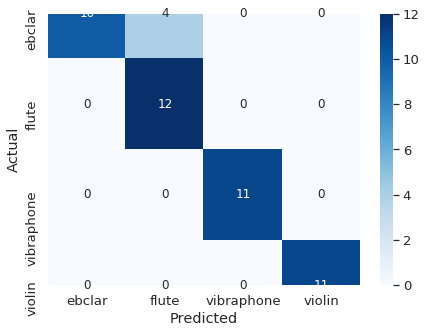

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

classes = np.unique(data_modif.instrument)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True);

**Stand-alone use of a trained model:** 

Now that we have a trained model, we have the tools to perform automatic instrument classification of isolated notes. Below, you find the code to run classification on audio files. This cell does not aim testing(beacuse it also includes the train samples) but just demonstration of running our model.

In [31]:
#Class names dictionary
classes = { 0: 'ebclar', 1: 'flute', 2: 'vibraphone', 3: 'violin'}

#Running prediction on individual files
for file in segment_files:
    #Extract features for a given file
    features, features_frames = es.MusicExtractor(lowlevelSilentFrames='drop',
                                                      lowlevelFrameSize = 2048,
                                                      lowlevelHopSize = 1024,
                                                      lowlevelStats = ['mean', 'stdev'])(file)
    #Pick the features we have used in our model
    selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
    #Applying learned scaling to the features
    scaled_features = min_max_scaler.transform(np.array(selected_features).reshape(1, -1))

    #Running prediction
    y_pred = clf.predict(scaled_features)

    #Printing the output
    print(file, " predicted as ", classes[y_pred[0]])

instrument/segments/Vibraphone_0.wav  predicted as  vibraphone
instrument/segments/Vibraphone_1.wav  predicted as  vibraphone
instrument/segments/Vibraphone_2.wav  predicted as  vibraphone
instrument/segments/Vibraphone_3.wav  predicted as  vibraphone
instrument/segments/Vibraphone_4.wav  predicted as  vibraphone
instrument/segments/Vibraphone_5.wav  predicted as  vibraphone
instrument/segments/Vibraphone_6.wav  predicted as  vibraphone
instrument/segments/Vibraphone_7.wav  predicted as  vibraphone
instrument/segments/Vibraphone_8.wav  predicted as  vibraphone
instrument/segments/Vibraphone_9.wav  predicted as  vibraphone
instrument/segments/Vibraphone_10.wav  predicted as  vibraphone
instrument/segments/Vibraphone_11.wav  predicted as  vibraphone
instrument/segments/Vibraphone_12.wav  predicted as  vibraphone
instrument/segments/Vibraphone_13.wav  predicted as  vibraphone
instrument/segments/Vibraphone_14.wav  predicted as  vibraphone
instrument/segments/Vibraphone_15.wav  predicted a